# Planetary Motion: Earth & Moon
## 20 March 2023

In [1]:
# Imports
using Plots, LinearAlgebra, LaTeXStrings
const G = 6.67430e-11  # Gravitational constant (m^3 kg^-1 s^-2)
default(fontfamily = "Computer Modern", size=(900,566), titlefont = (16), legendfontsize = 10, 
        guidefont = (16, :darkgreen), tickfont = (12, :black), 
        framestyle = :box, yminorgrid = true, legend = :outertopright, dpi=600)

# Physics background
Consider two gravitationally interacting planets:

<div> <img src="Planets.png" alt="Drawing" style="width: 400px;"/></div> 

The force on planet $i$ due to planet $j$ is given by
$$ \vec{F}_{ij} = \frac{G m_i m_j}{r_{ij}^2} \hat{r}_{ij}, $$
where 
$$ \hat{r}_{ij} = \frac{\vec{r}_{ij}}{r_{ij}}$$ 
and $\vec{r}_{ij} = \vec{r}_j - \vec{r}_i$. The force on planet $j$ exerts on planet $i$ is, by Newton's third law, the same magnitude but in the opposite direction. 

Now suppose we want to simulate the motion of these two objects. Newton's 2nd Law gives us

$$ m_i\frac{d\vec{v}_i}{dt} =  \frac{G m_i m_j}{r_{ij}^2} \hat{r}_{ij},$$

and 

$$ m_j \frac{d\vec{v}_j}{dt} =  \frac{G m_i m_j}{r_{ji}^2}  \hat{r}_{ji}.$$

Canceling masses, we are left with 

$$ \frac{d\vec{v}_i}{dt} =  \frac{G  m_j}{r_{ij}^2} \hat{r}_{ij},$$

and 
$$ \frac{d\vec{v}_j}{dt} =  \frac{G m_i }{r_{ji}^2} \hat{r}_{ji}.$$

Together with 

$$ \frac{d\vec{r}_i}{dt} = \vec{v_i}$$

$$ \frac{d\vec{r}_j}{dt} = \vec{v}_j$$

we have equations to simulate the system of two masses. 

# Simulation
## New Julia language feature: the struct 
Because we expect periodic motion, we will not use the Euler method, but rather the Euler-Cromer method.
Before jumping into writing this code, we will introduce a new feature of Julia: the *struct*. A *struct* is a custom type in Julia. The easiest way to see how this works is for me to define one. For this problem, I'll create a struct called Planet:

In [2]:
mutable struct Planet
    m::Float64             # mass
    r::Vector{Float64}     # position vector
    v::Vector{Float64}     # velocity vector
end

The above code defines a new type (called Planet) with three attributes: *m*, *r* and *v* (mass, position, and velocity). The types of each object are defined in the struct definition: mass is a floating point number, and r and v are vectors of floating point numbers. One additional feature is that I created a mutable struct so that the values of the position and velocity could be updated later on in this notebook. If I left off the *mutable* modifier, then Julia would not allow us to change any of the three attributes once they were set. 

Let's define the moon and the earth as two separate instances of Planet; I'll assume that the earth is at rest to start:

In [3]:
moon =  Planet(7.348e22, [3.84401e8, 0.0], [0.0, 1022]);
earth = Planet(5.972e24, [0.0, 0.0], [0.0, 0.0]);

Now suppose we want to find out the mass of the moon. We simply execute

In [4]:
moon.m

7.348e22

If you've done any object oriented programming, you'll see that this notation is identical. The velocity of the earth, for instance, is simply:

In [5]:
earth.v

2-element Vector{Float64}:
 0.0
 0.0

Where is the center of mass of the Earth-moon System? We simply use the definition of center of mass:
$$ \vec{r}_{\mathrm{cm}} = \frac{\sum m_i \vec{r}_i}{\sum m_i}$$


In [6]:
cm = (moon.m * moon.r .+ earth.m * earth.r)/(moon.m + earth.m)

2-element Vector{Float64}:
 4.672215519694053e6
 0.0

## Setting up simulation 
So, now let's define our system of two bodies:

In [7]:
bodies = [moon, earth]

2-element Vector{Planet}:
 Planet(7.348e22, [3.84401e8, 0.0], [0.0, 1022.0])
 Planet(5.972e24, [0.0, 0.0], [0.0, 0.0])

In [8]:
println(bodies[1].r)

[3.84401e8, 0.0]


Also, let's define time step, $\Delta t$, the simulation time, *tmax*, and the number of steps in the simulation:

In [9]:
Δt = 3600.0 # one hour
tmax = 86400 * 90 # 90 days
num_steps = Int(tmax/Δt)

2160

## Computing the acceleration
We will need to compute the acceleration of each object, so let's make a function to do this:


In [10]:
function accel(bodyi::Planet, bodyj::Planet)
    rij = bodyj.r .- bodyi.r
    r = norm(rij)
    aᵢ=  (G*bodyj.m/r^3)*rij
end

accel (generic function with 1 method)

## Implementing the Euler-Cromer method
Now let's write a function to implement the Euler-Cromer method. 
As written, the function below only returns an array of positions, 
however, it's easy to modify it to return other quantities. As you will
in HW09 :-).

In [11]:
function simulate(bodies, num_steps, Δt)
    num_bodies = length(bodies)
    positions = [zeros(num_steps, 2) for _ in 1:num_bodies]

    for i in 1:num_bodies    # initialize positions for all objects
        positions[i][1, :] = bodies[i].r
    end

    for step = 2:num_steps
        for i in 1:num_bodies
            a_total = zeros(2)
            for j in 1:num_bodies
                if i != j
                    a = accel(bodies[i], bodies[j])
                    a_total = a_total + a
                end
            end
            bodies[i].v =  bodies[i].v .+ a_total * Δt
            bodies[i].r = bodies[i].r .+ bodies[i].v * Δt
            positions[i][step, :] = bodies[i].r
        end
    end

    return positions
end  

simulate (generic function with 1 method)

## Running the simulation and plotting orbits

In [12]:
moon =  Planet(7.348e22, [3.84401e8, 0.0], [0.0, 1022]); # standard values for Earth's moon
earth = Planet(5.972e24, [0.0, 0.0], [0.0, 0.0]);        # standard value for Earth
#earth.v = - moon.m * moon.v / earth.m   # set Earth's initial velocity so that total momentum=0
bodies = [moon, earth]
Δt = 3600.0 # 1 hour
tmax = 86400 * 90 # 90 days
num_steps = Int(tmax/Δt)
# now run simulation
pos = simulate(bodies, num_steps, Δt);

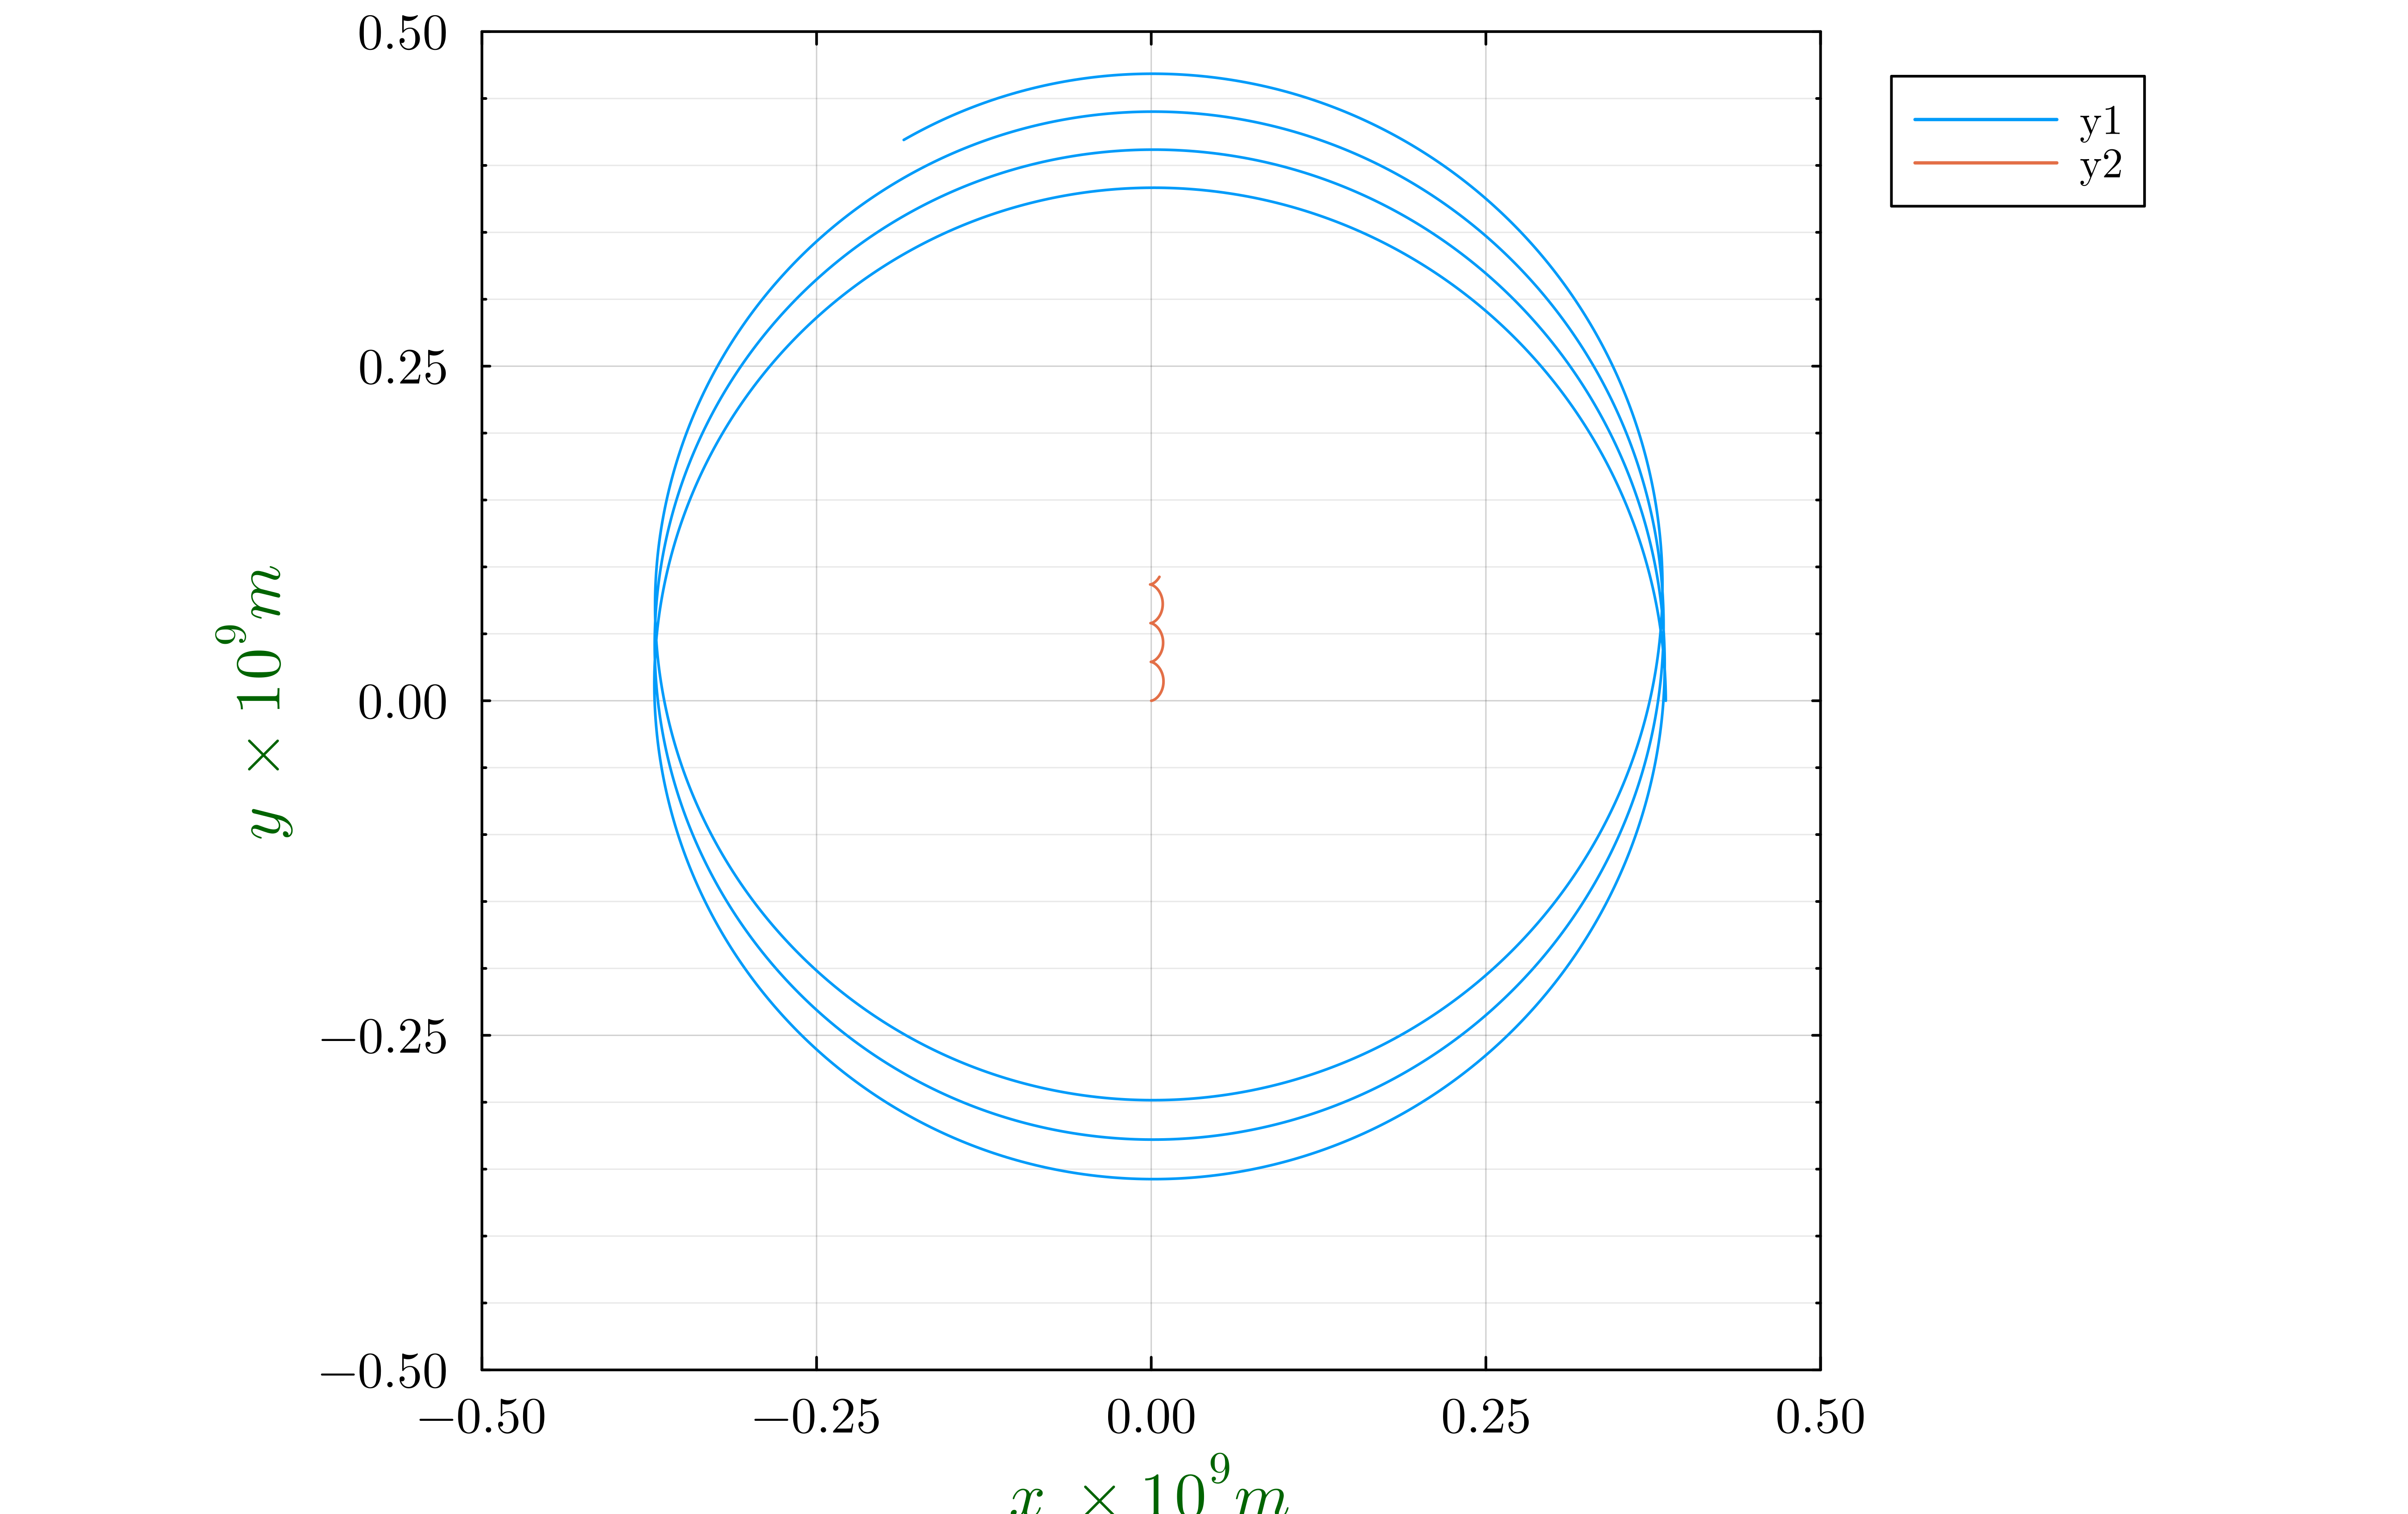

In [13]:
plot(pos[1][:, 1]/1e9, pos[1][ : ,2]/1e9, aspect_ratio=:equal, xlim = (-0.5, 0.5), ylim = (-0.5, 0.5))
plot!(pos[2][:, 1]/1e9, pos[2][ : ,2]/1e9, xlabel=L"x\;\times 10^9 m", ylabel=L"y\;\times 10^9 m")

Notice that Earth's orbit is a small (roughly) circular path in the center. As we demonstrated in class, this is 
not an artifact of our time step. Once you figure out why this plot is correct, you'll understand something about orbits that you might not have realized before. What is it?